# Comparison of SRI data files with flipchem and Kelley model

This notebook pulls a selected file from the SRI International ISR Database. The collision frequency data from this file is then compared to the flipchem model as well as the model from Kelley's textbook using the MSIS data from the same file.

In [1]:
# standard imports
import os
import datetime
import urllib.request

# 3rd party
import tables
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from flipchem import msis

In [2]:
def read_whole_h5file(fname):
    h5file=tables.open_file(fname)
    output={}
    for group in h5file.walk_groups("/"):
        output[group._v_pathname]={}
        for array in h5file.list_nodes(group, classname = 'Array'):
            output[group._v_pathname][array.name]=array.read()
    h5file.close()

    return output

In [3]:
# download an SRI processed file
outputfilepath = '20210721.001_ac_20min-fitcal.h5'
if not os.path.exists(outputfilepath):
    url='https://data.amisr.com/database/dbase_site_media/PFISR/Experiments/20210721.001/DataFiles/' + outputfilepath
    print('Downloading data file...')
    urllib.request.urlretrieve(url,outputfilepath)
    print('...Done!')

In [4]:
# read a data file


f = read_whole_h5file(outputfilepath)

#find east and west beams
be = np.argmin(76.09-np.abs(f['/']['BeamCodes'][:,1]))
bw = np.argmin(np.abs(-35.09-f['/']['BeamCodes'][:,1]))

# select direction
direction_index = bw

#load time and altitude array
t = [datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(t)) for t in f['/Time']['UnixTime'][:,0]]
h = f['/FittedParams']['Altitude']*1e-3 # convert meters to km
h = h[direction_index,:]

ne = f['/FittedParams']['Ne']

# load ion-neutral collision frequencies weighted by ion fractions 
nu0n = f['/FittedParams']['Fits'][:,direction_index,:,0,2]*f['/FittedParams']['Fits'][:,direction_index,:,0,0] #O+
nu1n = f['/FittedParams']['Fits'][:,direction_index,:,1,2]*f['/FittedParams']['Fits'][:,direction_index,:,1,0] #O2+
nu2n = f['/FittedParams']['Fits'][:,direction_index,:,2,2]*f['/FittedParams']['Fits'][:,direction_index,:,2,0] #NO+
nu3n = f['/FittedParams']['Fits'][:,direction_index,:,3,2]*f['/FittedParams']['Fits'][:,direction_index,:,3,0] #N2+
nu4n = f['/FittedParams']['Fits'][:,direction_index,:,4,2]*f['/FittedParams']['Fits'][:,direction_index,:,4,0] #N+

nu_sri = nu0n + nu1n + nu2n + nu3n + nu4n

# load ion fractions
fracs = f['/FittedParams']['Fits'][:,direction_index,:,0:5,0]

# average all time points
fracs = np.nanmean(fracs, axis=0)
nu_sri = np.nanmean(nu_sri, axis=0)

/home/asreimer/venvs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/asreimer/venvs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


In [5]:
# select altitude range
toph = 25  # default: toph = 25 : 186 km
minh = 3   # default: minh = 3  :  95 km

In [6]:
#load neutral msis data from SRI file (n in units 1/m^3)
nH = f['/MSIS']['nH'][:,direction_index,:]
nHe = f['/MSIS']['nHe'][:,direction_index,:]
nO = f['/MSIS']['nO'][:,direction_index,:]
nO2 = f['/MSIS']['nO2'][:,direction_index,:]
nAr = f['/MSIS']['nAr'][:,direction_index,:]
nN = f['/MSIS']['nN'][:,direction_index,:]
nN2 = f['/MSIS']['nN2'][:,direction_index,:]
nNO = f['/MSIS']['nNO'][:,direction_index,:]
Tn = f['/MSIS']['Tn'][:,direction_index,:]

#average all time points
nH = np.nanmean(nH, axis=0)
nHe = np.nanmean(nHe, axis=0)
nO = np.nanmean(nO, axis=0)
nO2 = np.nanmean(nO2, axis=0)
nAr = np.nanmean(nAr, axis=0)
nN = np.nanmean(nN, axis=0)
nN2 = np.nanmean(nN2, axis=0)
nNO = np.nanmean(nNO, axis=0)
Tn = np.nanmean(Tn, axis=0)

/home/asreimer/venvs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/asreimer/venvs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/home/asreimer/venvs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/asreimer/venvs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/home/asreimer/venvs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/asreimer/venvs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/home/asreimer/venvs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/asreimer/venvs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Me

In [7]:
#calculate collision freqs with flipchem and Kelley model
nu_flpch = []
nu_kel = []

#first for loop over all altitudes
for i in range(len(h)):
    dens = [nH[i], nHe[i], nN[i], nO[i], nN2[i], nO2[i], nAr[i]]
    mi = [16., 32., 30., 28., 14.]
    nu_flpch_new = 0.
    nu_kel_new = 0.

    #second for loop over all ion species
    for j in range(len(mi)):
        nu_flpch_new += msis.compute_ion_neutral_collfreq(dens, Tn[i], mi[j], Ti=None)*fracs[i,j]  
        nu_kel_new += 2.6e-9*np.sum(dens)*1e-6*(mi[j]**(-0.5))*fracs[i,j]

    nu_flpch.append(nu_flpch_new)
    nu_kel.append(nu_kel_new)

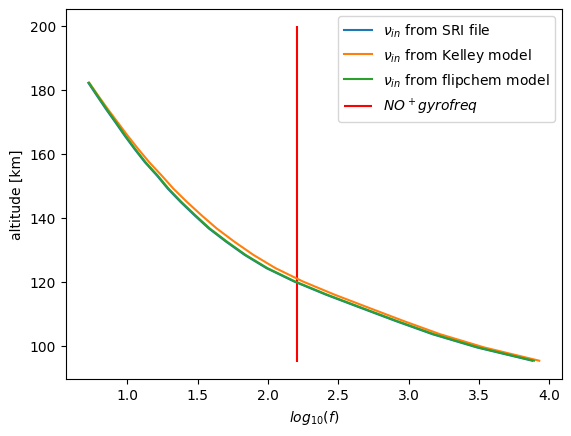

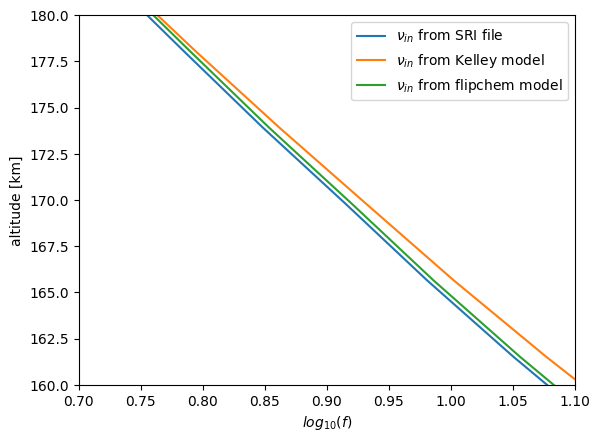

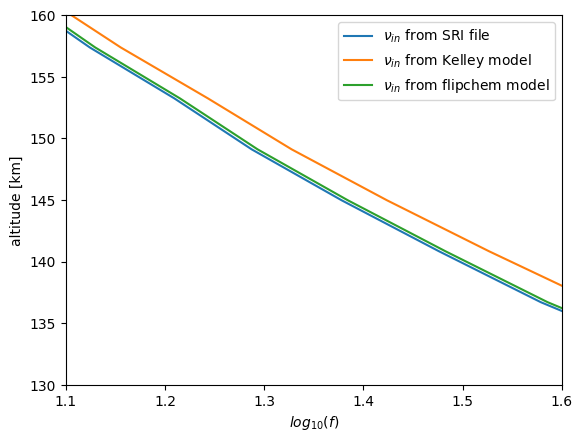

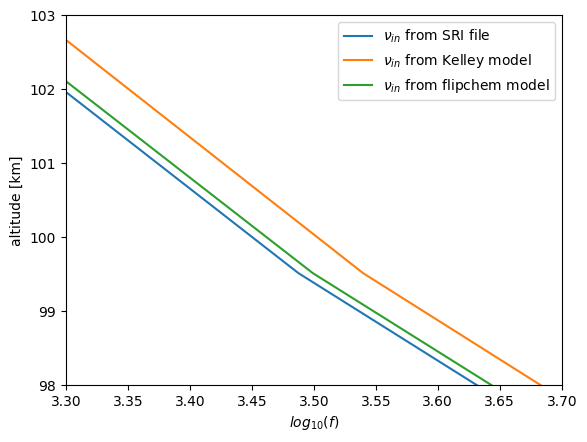

In [8]:
#comparison plots
plt.plot(np.log10(nu_sri[minh:toph]), h[minh:toph], label='$\\nu_{in}$ from SRI file')
plt.plot(np.log10(nu_kel[minh:toph]), h[minh:toph], label='$\\nu_{in}$ from Kelley model')
plt.plot(np.log10(nu_flpch[minh:toph]), h[minh:toph], label='$\\nu_{in}$ from flipchem model')
plt.ylabel('altitude [km]')
plt.xlabel('$log_{10}(f)$')
#draw NO+ gyrofrequency
plt.vlines(2.206,95,200, 'r', label='$NO^+ gyro freq$')
plt.legend()
plt.show()

plt.plot(np.log10(nu_sri[minh:toph]), h[minh:toph], label='$\\nu_{in}$ from SRI file')
plt.plot(np.log10(nu_kel[minh:toph]), h[minh:toph], label='$\\nu_{in}$ from Kelley model')
plt.plot(np.log10(nu_flpch[minh:toph]), h[minh:toph], label='$\\nu_{in}$ from flipchem model')
plt.ylabel('altitude [km]')
plt.xlabel('$log_{10}(f)$')
plt.legend()
#zoom in on higher altitudes
plt.ylim((160,180))
plt.xlim((0.7,1.1))
plt.show()


plt.plot(np.log10(nu_sri[minh:toph]), h[minh:toph], label='$\\nu_{in}$ from SRI file')
plt.plot(np.log10(nu_kel[minh:toph]), h[minh:toph], label='$\\nu_{in}$ from Kelley model')
plt.plot(np.log10(nu_flpch[minh:toph]), h[minh:toph], label='$\\nu_{in}$ from flipchem model')
plt.ylabel('altitude [km]')
plt.xlabel('$log_{10}(f)$')
plt.legend()
#zoom in on intermediate altitudes
plt.ylim((130,160))
plt.xlim((1.1,1.6))
plt.show()


plt.plot(np.log10(nu_sri[minh:toph]), h[minh:toph], label='$\\nu_{in}$ from SRI file')
plt.plot(np.log10(nu_kel[minh:toph]), h[minh:toph], label='$\\nu_{in}$ from Kelley model')
plt.plot(np.log10(nu_flpch[minh:toph]), h[minh:toph], label='$\\nu_{in}$ from flipchem model')
plt.ylabel('altitude [km]')
plt.xlabel('$log_{10}(f)$')
plt.legend()
#zoom in on lower altitudes
plt.ylim((98,103))
plt.xlim((3.3,3.7))
plt.show()